In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
root_dir = Path('./')

#
data_path = root_dir / 'training'
#

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(root=data_path/x, transform=data_transforms[x])
    for x in ['train', 'val']}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=1, shuffle=True)
    for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

X = defaultdict(list)
y = defaultdict(list)
for dataset in ['train', 'val']:
    for img, labels in dataloaders[dataset]:
        X[dataset].append(np.array(img).flatten())
        y[dataset].append(labels.item())
    X[dataset] = np.array(X[dataset])
    y[dataset] = np.array(y[dataset])

print('dataset size:', dataset_sizes)
print('class name:', class_names)

dataset size: {'train': 286, 'val': 72}
class name: ['0', '1', '2']


In [3]:
def learn(X, y, n):
    model = RandomForestClassifier(n_estimators=n, random_state=42, class_weight='balanced', n_jobs=-1)
    model.fit(X['train'], y['train'])

    score = {}
    for dataset in ['train', 'val']:
        score[dataset] = model.score(X[dataset], y[dataset])
    return score, model

In [4]:
best_model = None
best_val_score = 0.0
for i in (50, 100, 500, 1000, 1500, 2000, 2500, 3000):
    score, model = learn(X, y, i)
    print(f"本数：{i} 訓練用データでの正確度：{score['train']:.3f} テスト用データでの正確度：{score['val']:.3f}")
    if score['val'] > best_val_score:
        best_model = model
        best_val_score = score['val']
print()
print('best model:', best_model)
print('best score:', best_val_score)

本数：50 訓練用データでの正確度：1.000 テスト用データでの正確度：0.472
本数：100 訓練用データでの正確度：1.000 テスト用データでの正確度：0.528
本数：500 訓練用データでの正確度：1.000 テスト用データでの正確度：0.528
本数：1000 訓練用データでの正確度：1.000 テスト用データでの正確度：0.486
本数：1500 訓練用データでの正確度：1.000 テスト用データでの正確度：0.472
本数：2000 訓練用データでの正確度：1.000 テスト用データでの正確度：0.472
本数：2500 訓練用データでの正確度：1.000 テスト用データでの正確度：0.472
本数：3000 訓練用データでの正確度：1.000 テスト用データでの正確度：0.486

best model: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
best score: 0.5277777777777778


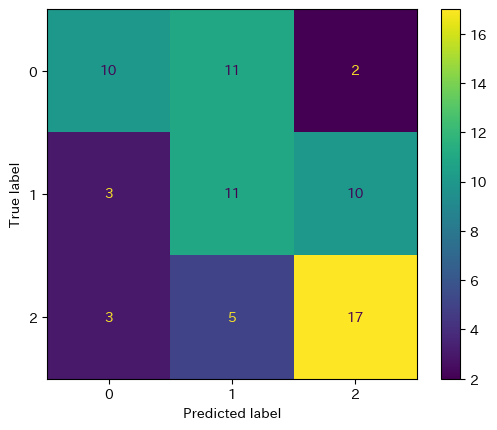

In [5]:
predicted = best_model.predict(X['val'])
ConfusionMatrixDisplay.from_predictions(y['val'], predicted)
plt.show()

In [6]:
def check_results(Xs, ys, preds, flag):
    H = 4
    W = 10
    fig = plt.figure(figsize=(W, H))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.4, wspace=0.4)

    i = 0
    for img, label, pred in zip(Xs, ys, preds):
        if (flag == 'success' and label == pred) or (flag == 'failed' and label != pred):
            plt.subplot(H, W, i+1)
            img = img.reshape(3, 64, 64).transpose(1, 2, 0)
            plt.imshow(img)
            plt.title(f'{label}->{pred}', fontsize=8)
            plt.axis('off')
            i += 1
            if i >= H * W:
                break
    plt.show()

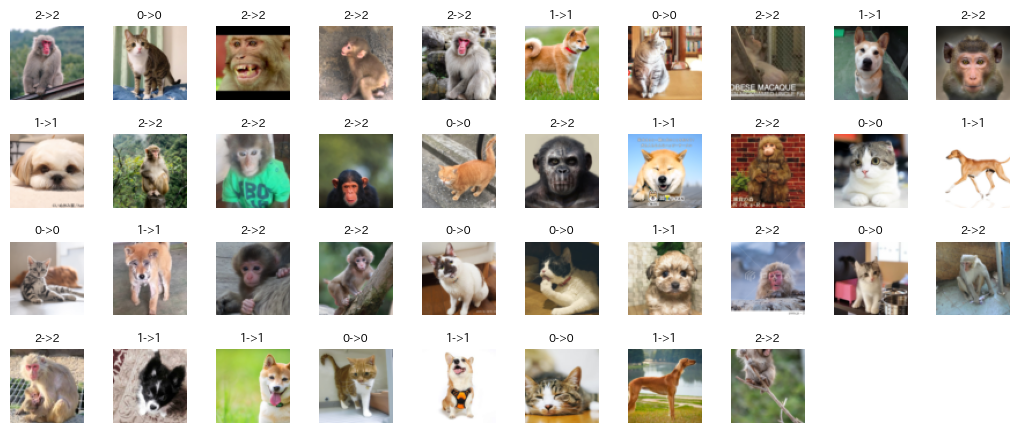

In [7]:
check_results(X['val'], y['val'], predicted, 'success')

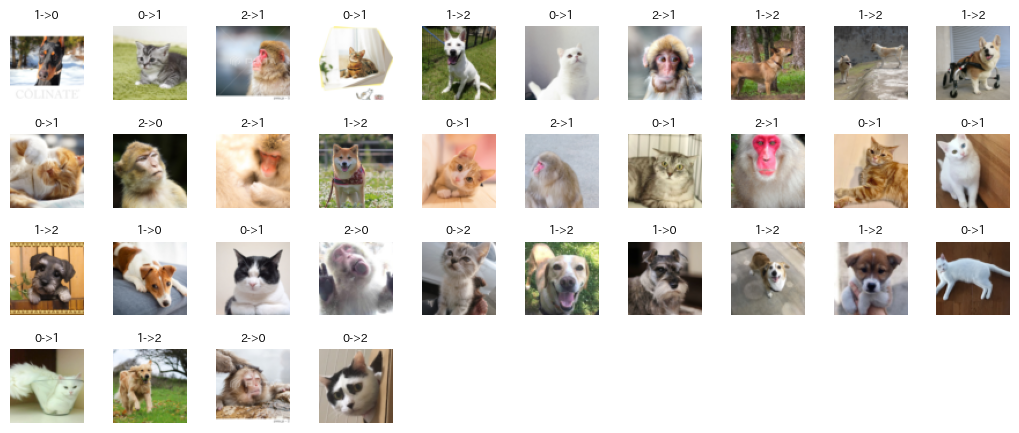

In [8]:
check_results(X['val'], y['val'], predicted, 'failed')